<a href="https://colab.research.google.com/github/WaquarH/my-scratch/blob/main/BPI__daaaa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pm4py
import numpy as np
import random
import pprint
import pandas as pd
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
tf.disable_eager_execution()

     |████████████████████████████████| 1.4MB 12.9MB/s 
     |████████████████████████████████| 40.6MB 90kB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23559 sha256=a4a01a3be53c03d8ce5e9494b2ae3d6b368e30a7c9f5b5d48125a1e7b819e3d9
  Stored in directory: /root/.cache/pip/wheels/c3/1b/bb/bf0de4d64d8ca38759811fe3353e441f12feb606fb3d1d2e11
Successfully built stringdist


In [ ]:
from pm4py.objects.log.importer.xes import importer as xes_importer
log = xes_importer.apply('/content/BPI Challenge 2017.xes.gz')

In [ ]:
from pm4py.objects.conversion.log import converter as log_converter
dataframe = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
dataframe.to_csv('/content/BPI2017.csv')
data=dataframe
data.head(5)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = pd.read_csv(r"/content/BPI2017.csv",  engine="c")

In [ ]:
data.keys()

Index(['Unnamed: 0', 'Action', 'org:resource', 'concept:name', 'EventOrigin',
       'EventID', 'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount', 'OfferID'],
      dtype='object')

In [ ]:
data=data[data['EventOrigin']!='Workflow']

In [ ]:
data=data.drop(['Action','org:resource','EventOrigin','EventID','lifecycle:transition','case:LoanGoal','case:ApplicationType','case:concept:name','OfferID'],axis=1)

In [ ]:
useful=['A_Cancelled','A_Pending','O_Create Offer','A_Denied']
data=data[data['concept:name'].isin(useful)].reset_index()
data

,index,Unnamed: 0,concept:name,time:timestamp,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount
0,9,9,O_Create Offer,2016-01-02 11:29:03.994000+00:00,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0
1,38,38,A_Pending,2016-01-14 15:49:11.420000+00:00,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50,50,O_Create Offer,2016-01-02 11:02:38.994000+00:00,10000.0,500.0,33.0,False,200.00,False,0.0,6000.0
3,68,68,A_Denied,2016-01-07 13:29:49.671000+00:00,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,79,79,O_Create Offer,2016-01-02 11:05:15.942000+00:00,15000.0,15000.0,120.0,True,158.98,False,0.0,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
74402,1202191,1202191,A_Pending,2017-01-23 07:44:22.568000+00:00,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74403,1202202,1202202,O_Create Offer,2017-01-04 19:30:29.845000+00:00,30000.0,0.0,77.0,True,450.00,True,996.0,30000.0
74404,1202244,1202244,A_Pending,2017-01-23 15:13:08.190000+00:00,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74405,1202254,1202254,O_Create Offer,2017-01-02 19:24:59.501000+00:00,20000.0,20000.0,77.0,False,297.81,False,0.0,20000.0


In [ ]:
statlist=[]
for i in range(len(data)):
    if data['concept:name'][i]=='O_Create Offer':
        stats=[]
        stats.append(data['case:RequestedAmount'][i])
        stats.append(data['FirstWithdrawalAmount'][i])
        stats.append(data['NumberOfTerms'][i])
        stats.append(data['Accepted'][i])
        stats.append(data['MonthlyCost'][i])
        stats.append(data['Selected'][i])
        stats.append(data['CreditScore'][i])
        stats.append(data['OfferedAmount'][i])
    elif data['concept:name'][i]=='A_Pending':
        stats.append(1)
        stats.append(0)
        stats.append(0)
        statlist.append(stats)
    elif data['concept:name'][i]=='A_Denied':
        stats.append(0)
        stats.append(1)
        stats.append(0)
        statlist.append(stats)
    else:
        stats.append(0)
        stats.append(0)
        stats.append(1)
        statlist.append(stats)

In [ ]:
statlist=pd.DataFrame(statlist,columns=['RequestedAmount','FirstWithdrawalAmount','NumberOfTerms','Accepted','MonthlyCost','Selected','CreditScore','OfferedAmount','A_Pending','A_Denied','A_Cancelled','NULL','NULL2','NULL3'])
statlist=statlist.drop(['NULL'],axis=1)
statlist=statlist.drop(['NULL2'],axis=1)
statlist=statlist.drop(['NULL3'],axis=1)

In [ ]:
statlist

,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,A_Pending,A_Denied,A_Cancelled
0,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,1,0,0
1,10000.0,500.0,33.0,False,200.00,False,0.0,6000.0,0,1,0
2,15000.0,15000.0,120.0,True,158.98,True,1059.0,15000.0,1,0,0
3,5000.0,3726.0,72.0,False,252.73,True,834.0,15700.0,1,0,0
4,35000.0,35000.0,120.0,True,366.08,False,0.0,35000.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
31407,12500.0,12500.0,71.0,True,204.21,True,1001.0,12500.0,1,0,0
31408,5000.0,5000.0,60.0,True,97.40,True,852.0,5000.0,1,0,0
31409,10000.0,10000.0,120.0,True,106.46,True,854.0,10000.0,1,0,0
31410,30000.0,0.0,77.0,True,450.00,True,996.0,30000.0,1,0,0


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label = LabelEncoder()
statlist['Accepted']=label.fit_transform(statlist['Accepted'])
statlist['Selected']=label.fit_transform(statlist['Selected'])

In [ ]:
dataX = (statlist[['RequestedAmount','FirstWithdrawalAmount','NumberOfTerms','Accepted','MonthlyCost','Selected','CreditScore','OfferedAmount']])
dataY = statlist[['A_Pending','A_Denied','A_Cancelled']]
dataX = np.asarray(dataX)
dataY = np.asarray(dataY)

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=42)
X_train=X_train.T
X_test=X_test.T
Y_train=Y_train.T
Y_test=Y_test.T

In [ ]:
X_train.shape

(8, 21046)

In [ ]:
Y_train.shape

(3, 21046)

In [ ]:
statlist

,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,A_Pending,A_Denied,A_Cancelled
0,20000.0,20000.0,44.0,1,498.29,1,979.0,20000.0,1,0,0
1,10000.0,500.0,33.0,0,200.00,0,0.0,6000.0,0,1,0
2,15000.0,15000.0,120.0,1,158.98,1,1059.0,15000.0,1,0,0
3,5000.0,3726.0,72.0,0,252.73,1,834.0,15700.0,1,0,0
4,35000.0,35000.0,120.0,1,366.08,0,0.0,35000.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
31407,12500.0,12500.0,71.0,1,204.21,1,1001.0,12500.0,1,0,0
31408,5000.0,5000.0,60.0,1,97.40,1,852.0,5000.0,1,0,0
31409,10000.0,10000.0,120.0,1,106.46,1,854.0,10000.0,1,0,0
31410,30000.0,0.0,77.0,1,450.00,1,996.0,30000.0,1,0,0


In [ ]:
def create_placeholders(n_x, n_y):

   
    X = tf.placeholder(tf.float32,[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,[n_y,None],name='Y')
    
    
    return X, Y

In [ ]:
def initialize_parameters():
    
    
    tf.set_random_seed(1)                   
    W1 = tf.get_variable('W1',[25,8],initializer=tf.glorot_uniform_initializer)
    b1 = tf.get_variable('b1',[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2',[12,25],initializer=tf.glorot_uniform_initializer)
    b2 = tf.get_variable('b2',[12,1],initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3',[3,12],initializer=tf.glorot_uniform_initializer)
    b3 = tf.get_variable('b3',[3,1],initializer=tf.zeros_initializer())
   

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [ ]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    
    Z1 = tf.add(tf.matmul(W1,X),b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                              # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                              # Z3 = np.dot(W3, A2) + b3

    return Z3

In [ ]:
def compute_cost(Z3, Y):
    
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
   
    
    return cost

In [ ]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1000, minibatch_size = 32, print_cost = True):
   
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
   
    X, Y = create_placeholders(n_x, n_y)
    

   
    parameters = initialize_parameters()
  
    
    
    Z3 = forward_propagation(X, parameters)
    
    
    # Cost function: Add cost function to tensorflow graph
   
    cost = compute_cost(Z3, Y)
   
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
   
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
   
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
               
                _ , minibatch_cost = sess.run([optimizer, cost],{X: minibatch_X, Y: minibatch_Y})
               
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float64"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 56546.182565
Cost after epoch 100: 55.008466
Cost after epoch 200: 36.157322
Cost after epoch 300: 31.174706
Cost after epoch 400: 29.764583
Cost after epoch 500: 24.911339
Cost after epoch 600: 27.309716
Cost after epoch 700: 22.913831
Cost after epoch 800: 21.799392
Cost after epoch 900: 19.695724


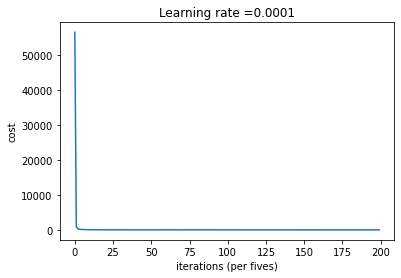

Parameters have been trained!
Train Accuracy: 0.8221514777154804
Test Accuracy: 0.8224001543507621


In [ ]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [ ]:
parameters

{'W1': array([[ 2.25022569e-01, -3.01831901e-01,  1.31312281e-01,
          5.08779287e+00, -1.91463251e-02, -1.50394268e+01,
          6.28739715e-01,  3.04463118e-01],
        [ 1.90881953e-01,  3.58487487e-01, -2.24094123e-01,
          1.99774146e+00,  8.30871314e-02,  3.33005333e+00,
          5.68787634e-01,  9.18955132e-02],
        [ 2.17325285e-01,  1.11011297e-01,  6.64958879e-02,
         -1.54602814e+00, -1.30084068e-01,  1.00082693e+01,
         -6.52670920e-01, -1.20250151e-01],
        [-3.92934203e-01, -3.69067401e-01, -1.47430480e-01,
         -8.06006789e-03, -3.28728139e-01, -1.33066148e-01,
          1.89779699e-02, -1.65658385e-01],
        [ 2.90726155e-01,  1.28232285e-01,  1.38023213e-01,
         -3.73524427e+00, -2.65345778e-02,  2.30063076e+01,
          5.46083331e-01,  1.24879830e-01],
        [ 5.98742887e-02, -3.23509127e-01,  2.66672403e-01,
          4.03879613e-01,  3.04104447e-01, -4.85979229e-01,
         -2.92599082e-01, -5.42090178e-01],
        [ 

In [ ]:
def prediction(X_val,Y_val,parameters):
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]
    X, Y = create_placeholders(n_x, n_y)
    Z3 = forward_propagation(X, parameters)
    predict = tf.argmax(Z3)
    Y_act=tf.argmax(Y)
    cost = compute_cost(Z3, Y)
    with tf.Session() as sess:
        Y_pred,Y_actual =  sess.run([predict,Y_act],{X:X_val,Y:Y_val})
    return Y_pred,Y_actual

In [ ]:
Y_pred,Y_actual=prediction(X_test,Y_test,parameters)

In [ ]:
def scores(Y_pred,Y_actual):
    arr=Y_actual[(Y_pred==Y_actual)]
    for i in range(3):
        tp=len(arr[arr==i])
        false=len(Y_actual[(Y_pred!=Y_actual)])
        fp= len((Y_actual[Y_pred !=Y_actual][Y_actual[Y_pred != Y_actual]==i]))
        fn= len((Y_actual[Y_pred !=Y_actual][Y_pred[Y_pred != Y_actual]==i]))
        precision=tp/(tp+fp)
        recall= tp/(tp+fn)
        #tn=len(Y_actual[(Y_pred==0 and (Y_actual==0))])
        F_score= 2*tp/(2*tp+false)
        print("precision of "+ str(i) +" is " + str(precision))
        print("recall of "+ str(i) +" is " + str(recall))
        print("F1_score of "+ str(i) +" is " + str(F_score)) #formula for F1_score is: 2*precision*recall/(recall+precision)
    print("\n\nThus F1_score for failure is "+ str(F_score)) 

In [ ]:
scores(Y_pred,Y_actual)

precision of 0 is 0.9366713189113748
recall of 0 is 0.8537128319287645
F1_score of 0 is 0.8536449638286032
precision of 1 is 0.25020441537203597
recall of 1 is 0.864406779661017
F1_score of 1 is 0.24949041989400733
precision of 2 is 0.8355321020228672
recall of 2 is 0.765511684125705
F1_score of 2 is 0.7558679220262564


Thus F1_score for failure is 0.7558679220262564
